# Analysis Market Price using mplfinace

## 0. Preparation

### 0.1 Imports

In [1]:
# only for live plot
#%matplotlib widget 
import urllib.request
import json, time
import mplfinance as mpf
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (14, 8)
#plt.rc('font', family='Cascadia Code PL')
import numpy as np
import pandas as pd
pd.options.plotting.backend = 'matplotlib'
pd.set_option('display.max_columns', 0)
import pprint
pp = pprint.PrettyPrinter(indent=4)

BASEURL = 'http://localhost:18080/kabusapi/'
BASEURL_TEST = 'http://localhost:18081/kabusapi/'

### 0.2 Functions

#### Groupby Time

In [2]:
# freq = 1s, 1min, 5min, 1h, ...
def groupByTime(df, col, freq='1s'):
    df[col+'Time'] = pd.to_datetime(df[col+'Time'])
    df_sel = data.loc[:, [col+'Time', col]]
    df_gb = df_sel.groupby(pd.Grouper(key=col+'Time', freq=freq))
    return df_gb

#### Create Stock data

In [3]:
def CreateStockData(df, col, freq='1s'):
    df_gb = groupByTime(df, col, freq=freq)
    df_vol = groupByTime(df, 'TradingVolume', freq=freq).max()
    df_vol = df_vol.diff()
    df_stock = pd.concat([df_gb.first(), df_gb.max(), df_gb.min(), df_gb.last(), df_vol], axis=1)
    df_stock = df_stock.set_axis(['Open', 'High', 'Low', 'Close', 'Volume'], axis='columns')
    return df_stock

#### mpfplot

In [4]:
def mpfplot(data, **kwargs):
    style = mpf.make_mpf_style(base_mpf_style='nightclouds', rc={"font.family":'MS Gothic'})
    return mpf.plot(data, figsize=(12, 6), style=style, returnfig=True, **kwargs)

## 1. Data

In [37]:
data = pd.read_csv('../data/20210921_push_raw.csv')
print('data.shape:, ', data.shape)
data.head()

data.shape:,  (41870, 82)


,Unnamed: 0,OverSellQty,UnderBuyQty,TotalMarketValue,MarketOrderSellQty,MarketOrderBuyQty,BidTime,AskTime,Exchange,ExchangeName,TradingVolume,TradingVolumeTime,VWAP,TradingValue,BidQty,BidPrice,BidSign,AskQty,AskPrice,AskSign,Symbol,SymbolName,CurrentPrice,CurrentPriceTime,CurrentPriceChangeStatus,CurrentPriceStatus,CalcPrice,PreviousClose,PreviousCloseTime,ChangePreviousClose,ChangePreviousClosePer,OpeningPrice,OpeningPriceTime,HighPrice,HighPriceTime,LowPrice,LowPriceTime,SecurityType,Buy1_Sign,Buy1_Time,Buy1_Price,Buy1_Qty,Buy2_Price,Buy2_Qty,Buy3_Price,Buy3_Qty,Buy4_Price,Buy4_Qty,Buy5_Price,Buy5_Qty,Buy6_Price,Buy6_Qty,Buy7_Price,Buy7_Qty,Buy8_Price,Buy8_Qty,Buy9_Price,Buy9_Qty,Buy10_Price,Buy10_Qty,Sell1_Sign,Sell1_Time,Sell1_Price,Sell1_Qty,Sell2_Price,Sell2_Qty,Sell3_Price,Sell3_Qty,Sell4_Price,Sell4_Qty,Sell5_Price,Sell5_Qty,Sell6_Price,Sell6_Qty,Sell7_Price,Sell7_Qty,Sell8_Price,Sell8_Qty,Sell9_Price,Sell9_Qty,Sell10_Price,Sell10_Qty
0,0,3735700.0,1620300.0,5.501829e+12,0.0,0.0,2021-09-21T09:03:15+09:00,2021-09-21T09:03:15+09:00,1,東証１部,1210900.0,2021-09-21T09:03:16+09:00,716.2384,867293050.0,1000.0,718.7,101,500.0,718.4,101,4689,Ｚホールディングス,718.6,2021-09-21T09:03:16+09:00,58,1,718.6,738.1,2021-09-17T00:00:00+09:00,-19.5,-2.64,716.2,2021-09-21T09:03:00+09:00,718.7,2021-09-21T09:03:15+09:00,714.1,2021-09-21T09:03:01+09:00,1,101,2021-09-21T09:03:15+09:00,718.4,500.0,718.3,900.0,718.2,1600.0,718.0,400.0,717.9,400.0,717.8,100.0,717.7,500.0,717.6,700.0,717.2,100.0,716.9,100.0,101,2021-09-21T09:03:15+09:00,718.7,1000.0,718.8,900.0,718.9,1100.0,719.1,500.0,719.2,1100.0,719.4,500.0,719.5,1500.0,719.6,600.0,719.7,2800.0,719.8,700.0
1,0,3735700.0,1620300.0,5.501829e+12,0.0,0.0,2021-09-21T09:03:15+09:00,2021-09-21T09:03:15+09:00,1,東証１部,1213600.0,2021-09-21T09:03:16+09:00,716.2436,869233220.0,1000.0,718.7,101,500.0,718.4,101,4689,Ｚホールディングス,718.7,2021-09-21T09:03:16+09:00,56,1,718.6,738.1,2021-09-17T00:00:00+09:00,-19.4,-2.63,716.2,2021-09-21T09:03:00+09:00,718.7,2021-09-21T09:03:15+09:00,714.1,2021-09-21T09:03:01+09:00,1,101,2021-09-21T09:03:15+09:00,718.4,500.0,718.3,900.0,718.2,1600.0,718.0,400.0,717.9,400.0,717.8,100.0,717.7,500.0,717.6,700.0,717.2,100.0,716.9,100.0,101,2021-09-21T09:03:15+09:00,718.7,1000.0,718.8,900.0,718.9,1100.0,719.1,500.0,719.2,1100.0,719.4,500.0,719.5,1500.0,719.6,600.0,719.7,2800.0,719.8,700.0
2,0,3735700.0,1620300.0,5.502594e+12,0.0,0.0,2021-09-21T09:03:15+09:00,2021-09-21T09:03:15+09:00,1,東証１部,1213600.0,2021-09-21T09:03:16+09:00,716.2436,869233220.0,1000.0,718.7,101,500.0,718.4,101,4689,Ｚホールディングス,718.7,2021-09-21T09:03:16+09:00,56,1,718.7,738.1,2021-09-17T00:00:00+09:00,-19.4,-2.63,716.2,2021-09-21T09:03:00+09:00,718.7,2021-09-21T09:03:15+09:00,714.1,2021-09-21T09:03:01+09:00,1,101,2021-09-21T09:03:15+09:00,718.4,500.0,718.3,900.0,718.2,1600.0,718.0,400.0,717.9,400.0,717.8,100.0,717.7,500.0,717.6,700.0,717.2,100.0,716.9,100.0,101,2021-09-21T09:03:15+09:00,718.7,1000.0,718.8,900.0,718.9,1100.0,719.1,500.0,719.2,1100.0,719.4,500.0,719.5,1500.0,719.6,600.0,719.7,2800.0,719.8,700.0
3,0,3678700.0,1620300.0,5.502594e+12,0.0,0.0,2021-09-21T09:03:16+09:00,2021-09-21T09:03:16+09:00,1,東証１部,1213600.0,2021-09-21T09:03:16+09:00,716.2436,869233220.0,200.0,718.8,101,800.0,718.4,101,4689,Ｚホールディングス,718.7,2021-09-21T09:03:16+09:00,56,1,718.7,738.1,2021-09-17T00:00:00+09:00,-19.4,-2.63,716.2,2021-09-21T09:03:00+09:00,718.7,2021-09-21T09:03:15+09:00,714.1,2021-09-21T09:03:01+09:00,1,101,2021-09-21T09:03:16+09:00,718.4,800.0,718.3,1400.0,718.2,500.0,718.0,400.0,717.9,400.0,717.8,100.0,717.7,500.0,717.6,700.0,717.2,1000.0,716.9,100.0,101,2021-09-21T09:03:16+09:00,718.8,200.0,718.9,900.0,719.1,500.0,719.2,1100.0,719.4,500.0,719.5,1500.0,719.7,2800.0,719.8,1600.0,719.9,700.0,720.0,57400.0
4,0,3678900.0,1620100.0,5.502594e+12,0.0,0.0,2021-09-21T09:03:16+09:00,2021-09-21T09:03:16+09:00,1,東証１部,1213600.0,2021-09-21T09:03:16+09:00,716.2436,869233220.0,200.0,718.8,101,800.0,718.4,101,4689,Ｚホールディングス,718.7,2021-09-21T09:03:16+09:00,5

### write and read via sqlite3

In [41]:
import sqlite3
con = sqlite3.connect('D://data/temp2.db')

In [45]:
def to_datetime(df):
    for col in df.columns:
        if 'Time' in col:
            df[col] = pd.to_datetime(df[col])
    return df

In [63]:
data = to_datetime(data)
data.to_sql('test_data', con, if_exists='append', index=None)

C:\Users\eunchong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\generic.py:2872: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


In [48]:
df = pd.read_sql('SELECT * from test_data', con).iloc[: , 1:]
df.head()

,OverSellQty,UnderBuyQty,TotalMarketValue,MarketOrderSellQty,MarketOrderBuyQty,BidTime,AskTime,Exchange,ExchangeName,TradingVolume,TradingVolumeTime,VWAP,TradingValue,BidQty,BidPrice,BidSign,AskQty,AskPrice,AskSign,Symbol,SymbolName,CurrentPrice,CurrentPriceTime,CurrentPriceChangeStatus,CurrentPriceStatus,CalcPrice,PreviousClose,PreviousCloseTime,ChangePreviousClose,ChangePreviousClosePer,OpeningPrice,OpeningPriceTime,HighPrice,HighPriceTime,LowPrice,LowPriceTime,SecurityType,Buy1_Sign,Buy1_Time,Buy1_Price,Buy1_Qty,Buy2_Price,Buy2_Qty,Buy3_Price,Buy3_Qty,Buy4_Price,Buy4_Qty,Buy5_Price,Buy5_Qty,Buy6_Price,Buy6_Qty,Buy7_Price,Buy7_Qty,Buy8_Price,Buy8_Qty,Buy9_Price,Buy9_Qty,Buy10_Price,Buy10_Qty,Sell1_Sign,Sell1_Time,Sell1_Price,Sell1_Qty,Sell2_Price,Sell2_Qty,Sell3_Price,Sell3_Qty,Sell4_Price,Sell4_Qty,Sell5_Price,Sell5_Qty,Sell6_Price,Sell6_Qty,Sell7_Price,Sell7_Qty,Sell8_Price,Sell8_Qty,Sell9_Price,Sell9_Qty,Sell10_Price,Sell10_Qty
0,3735700.0,1620300.0,5.501829e+12,0.0,0.0,2021-09-21 09:03:15+09:00,2021-09-21 09:03:15+09:00,1,東証１部,1210900.0,2021-09-21 09:03:16+09:00,716.2384,867293050.0,1000.0,718.7,101,500.0,718.4,101,4689,Ｚホールディングス,718.6,2021-09-21 09:03:16+09:00,58,1,718.6,738.1,2021-09-17 00:00:00+09:00,-19.5,-2.64,716.2,2021-09-21 09:03:00+09:00,718.7,2021-09-21 09:03:15+09:00,714.1,2021-09-21 09:03:01+09:00,1,101,2021-09-21 09:03:15+09:00,718.4,500.0,718.3,900.0,718.2,1600.0,718.0,400.0,717.9,400.0,717.8,100.0,717.7,500.0,717.6,700.0,717.2,100.0,716.9,100.0,101,2021-09-21 09:03:15+09:00,718.7,1000.0,718.8,900.0,718.9,1100.0,719.1,500.0,719.2,1100.0,719.4,500.0,719.5,1500.0,719.6,600.0,719.7,2800.0,719.8,700.0
1,3735700.0,1620300.0,5.501829e+12,0.0,0.0,2021-09-21 09:03:15+09:00,2021-09-21 09:03:15+09:00,1,東証１部,1213600.0,2021-09-21 09:03:16+09:00,716.2436,869233220.0,1000.0,718.7,101,500.0,718.4,101,4689,Ｚホールディングス,718.7,2021-09-21 09:03:16+09:00,56,1,718.6,738.1,2021-09-17 00:00:00+09:00,-19.4,-2.63,716.2,2021-09-21 09:03:00+09:00,718.7,2021-09-21 09:03:15+09:00,714.1,2021-09-21 09:03:01+09:00,1,101,2021-09-21 09:03:15+09:00,718.4,500.0,718.3,900.0,718.2,1600.0,718.0,400.0,717.9,400.0,717.8,100.0,717.7,500.0,717.6,700.0,717.2,100.0,716.9,100.0,101,2021-09-21 09:03:15+09:00,718.7,1000.0,718.8,900.0,718.9,1100.0,719.1,500.0,719.2,1100.0,719.4,500.0,719.5,1500.0,719.6,600.0,719.7,2800.0,719.8,700.0
2,3735700.0,1620300.0,5.502594e+12,0.0,0.0,2021-09-21 09:03:15+09:00,2021-09-21 09:03:15+09:00,1,東証１部,1213600.0,2021-09-21 09:03:16+09:00,716.2436,869233220.0,1000.0,718.7,101,500.0,718.4,101,4689,Ｚホールディングス,718.7,2021-09-21 09:03:16+09:00,56,1,718.7,738.1,2021-09-17 00:00:00+09:00,-19.4,-2.63,716.2,2021-09-21 09:03:00+09:00,718.7,2021-09-21 09:03:15+09:00,714.1,2021-09-21 09:03:01+09:00,1,101,2021-09-21 09:03:15+09:00,718.4,500.0,718.3,900.0,718.2,1600.0,718.0,400.0,717.9,400.0,717.8,100.0,717.7,500.0,717.6,700.0,717.2,100.0,716.9,100.0,101,2021-09-21 09:03:15+09:00,718.7,1000.0,718.8,900.0,718.9,1100.0,719.1,500.0,719.2,1100.0,719.4,500.0,719.5,1500.0,719.6,600.0,719.7,2800.0,719.8,700.0
3,3678700.0,1620300.0,5.502594e+12,0.0,0.0,2021-09-21 09:03:16+09:00,2021-09-21 09:03:16+09:00,1,東証１部,1213600.0,2021-09-21 09:03:16+09:00,716.2436,869233220.0,200.0,718.8,101,800.0,718.4,101,4689,Ｚホールディングス,718.7,2021-09-21 09:03:16+09:00,56,1,718.7,738.1,2021-09-17 00:00:00+09:00,-19.4,-2.63,716.2,2021-09-21 09:03:00+09:00,718.7,2021-09-21 09:03:15+09:00,714.1,2021-09-21 09:03:01+09:00,1,101,2021-09-21 09:03:16+09:00,718.4,800.0,718.3,1400.0,718.2,500.0,718.0,400.0,717.9,400.0,717.8,100.0,717.7,500.0,717.6,700.0,717.2,1000.0,716.9,100.0,101,2021-09-21 09:03:16+09:00,718.8,200.0,718.9,900.0,719.1,500.0,719.2,1100.0,719.4,500.0,719.5,1500.0,719.7,2800.0,719.8,1600.0,719.9,700.0,720.0,57400.0
4,3678900.0,1620100.0,5.502594e+12,0.0,0.0,2021-09-21 09:03:16+09:00,2021-09-21 09:03:16+09:00,1,東証１部,1213600.0,2021-09-21 09:03:16+09:00,716.2436,869233220.0,200.0,718.8,101,800.0,718.4,101,4689,Ｚホールディングス,718.7,2021-09-21 09:03:16+09:00,56,1,718.7,738.1,2021-

In [61]:
df.iloc[-1].CurrentPriceTime

'2021-09-21 15:00:00+09:00'

## 2. Plots

### line plot

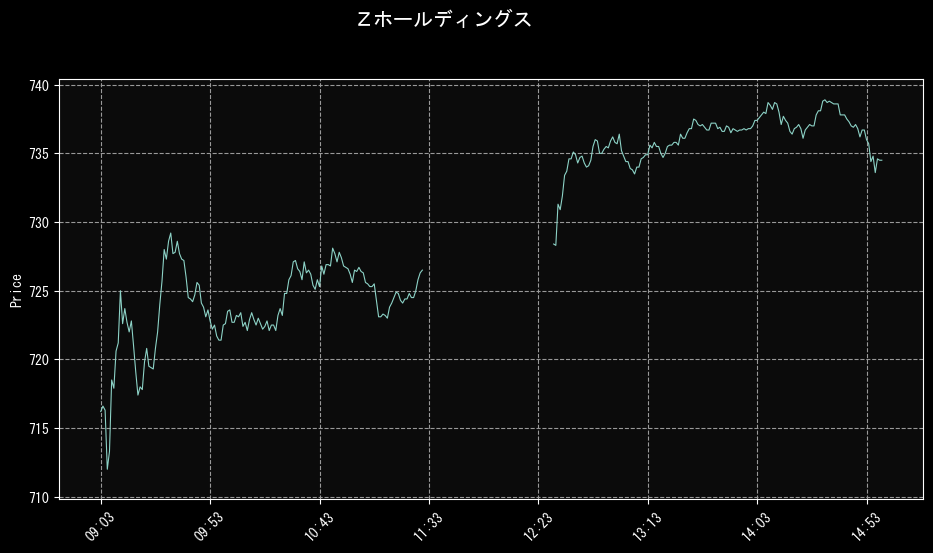

In [8]:
df = CreateStockData(data, 'CurrentPrice', '1min')
fig, ax = mpfplot(df, type='line', title=data.SymbolName[0])

### Candle plot

(<Figure size 1200x600 with 4 Axes>,
 [<Axes:ylabel='Price'>, <Axes:>, <Axes:ylabel='Volume  $10^{6}$'>, <Axes:>])

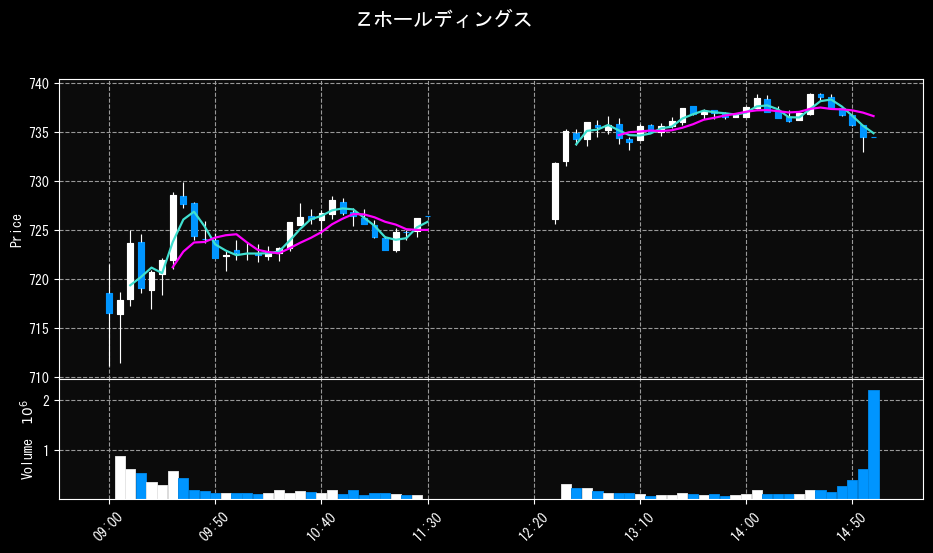

In [9]:
cp_5m = CreateStockData(data, 'CurrentPrice', '5min')
mpfplot(cp_5m, type='candle', mav=(3, 7), title=data.SymbolName[0], volume=True)

### live plot
- live plot needs `%matplotlib widget`
- plots will not apprear after file load
- plots will not apprear on GitHub
1. first create `fig` and `ax`
2. parse `ax` to update the content
3. use `fig.canvas.draw()` to force update

Reference:
- https://github.com/matplotlib/mplfinance/issues/264

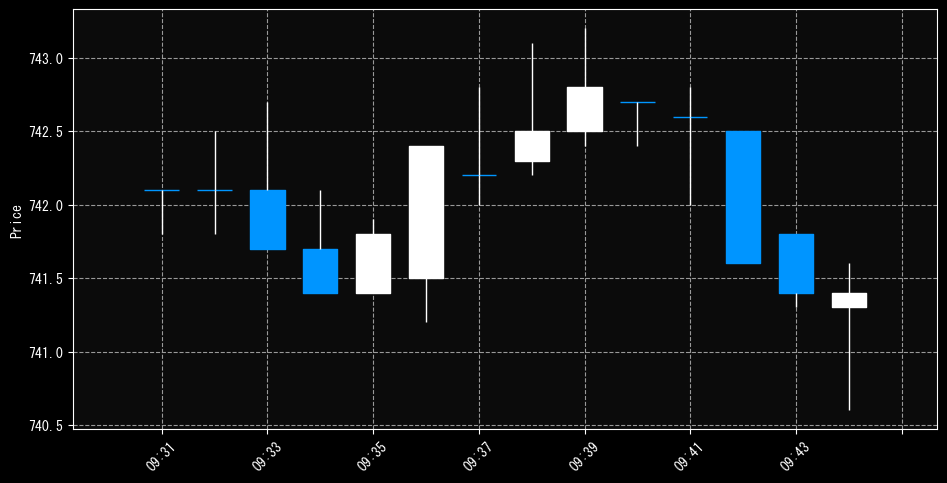

In [8]:
df = CreateStockData(data, 'CurrentPrice', '1min')
fig, ax = mpfplot(df[0:5], type='candle')

# when parse `ax`, must not parse figsize and returning=True
def mpfplotLive(data, **kwargs):
    style = mpf.make_mpf_style(base_mpf_style='nightclouds', rc={"font.family":'MS Gothic'})
    return mpf.plot(data, style=style, **kwargs)

for i in range(10):
    ax[0].clear()
    mpfplotLive(df[0:5+i], type='candle', ax=ax[0])
    fig.canvas.draw()
    #fig.canvas.flush_events()
    time.sleep(1)

### Time based increasing

(<Figure size 1200x600 with 2 Axes>, [<Axes:ylabel='Price'>, <Axes:>])

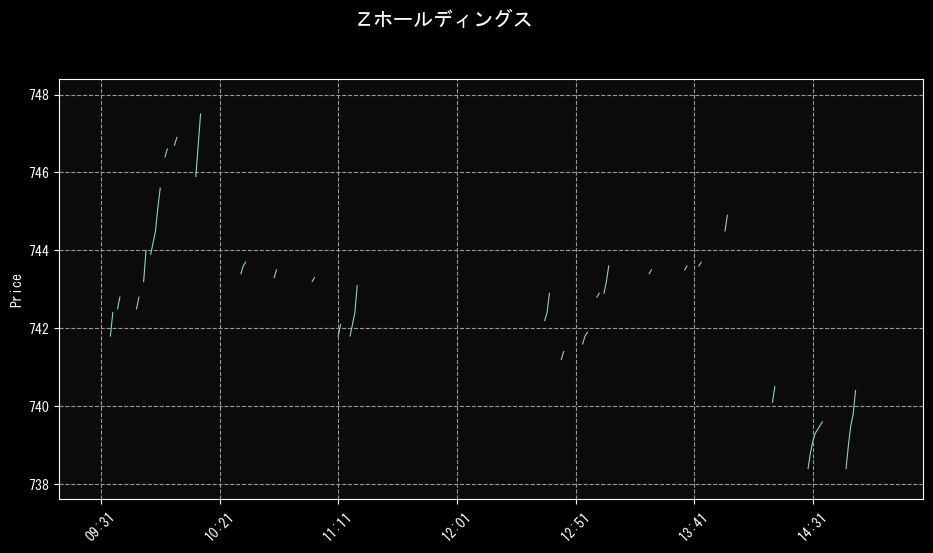

In [9]:
cp_1min = CreateStockData(data, 'CurrentPrice', '1min')
mpfplot(cp_1min[cp_1min > cp_1min.shift()], type='line', title=data.SymbolName[0])

### Diff plot

(<Figure size 1200x600 with 2 Axes>, [<Axes:ylabel='Price'>, <Axes:>])

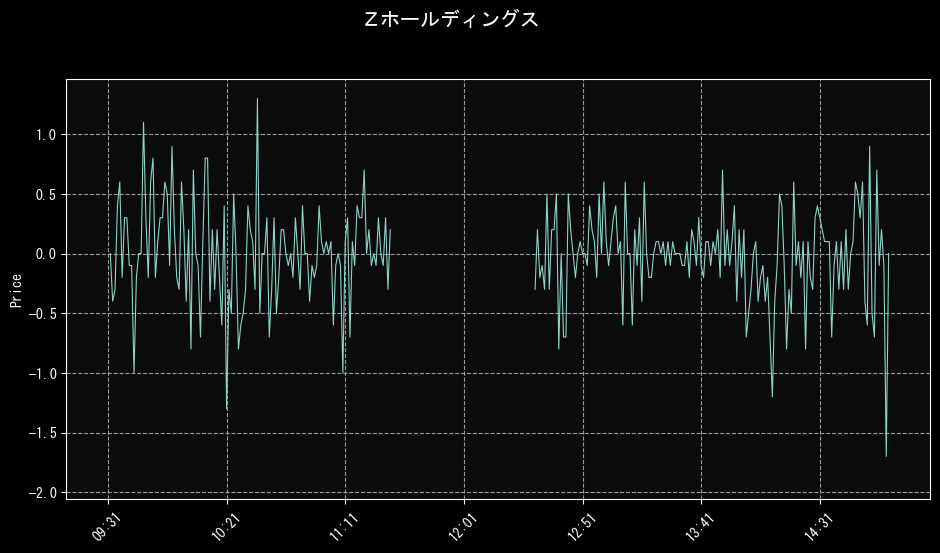

In [10]:
cp_1min = CreateStockData(data, 'CurrentPrice', '1min')
mpfplot(cp_1min.diff(), type='line', title=data.SymbolName[0])